# Time Series lecture
by Matthew Drury, adapted by F. Burkholder

The approach used to predict future values in time series data is called forecasting.

## Forecasting

From Rob Hyndman's **free** online text [Forecasting, Principle and Practice](https://otexts.com/fpp3/):

"Forecasting has fascinated people for thousands of years, sometimes being considered a sign of divine inspiration, and sometimes being seen as a criminal activity. The Jewish prophet Isaiah wrote in about 700 BC

    Tell us what the future holds, so we may know that you are gods.
    (Isaiah 41:23)

One hundred years later, in ancient Babylon, forecasters would foretell the future based on the distribution of maggots in a rotten sheep’s liver. By 300 BC, people wanting forecasts would journey to Delphi in Greece to consult the Oracle, who would provide her predictions while intoxicated by ethylene vapours. Forecasters had a tougher time under the emperor Constantine, who issued a decree in AD357 forbidding anyone 'to consult a soothsayer, a mathematician, or a forecaster …  May curiosity to foretell the future be silenced forever.'

A similar ban on forecasting occurred in England in 1736 when it became an offence to defraud by charging money for predictions. The punishment was three months’ imprisonment with hard labour!

The varying fortunes of forecasters arise because good forecasts can seem almost magical, while bad forecasts may be dangerous. Consider the following famous predictions about computing.

    I think there is a world market for maybe five computers. (Chairman of IBM, 1943)
    Computers in the future may weigh no more than 1.5 tons. (Popular Mechanics, 1949)
    There is no reason anyone would want a computer in their home. (President, DEC, 1977)"


### Objectives
* Be able to describe what a time-series is, and why analyzing it can be complicated
* Define a time-series _trend_.  &nbsp; What does it mean to _de-trend_ a time-series?
* Define a time-series _season_.  &nbsp; What does it mean to _de-seasonalize_ a time-series?
* Describe a straight-forward, interpretable way of doing time-series analysis: **trend-season-residual decomposition**
* Introduce other methods
  * ARIMA
  * Supervised learning using lagged features
  * Recurrent neural networks (LSTMs)

In [1]:
import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Always make it pretty.
plt.style.use('ggplot')

# We get some interger -> float typecast warning from sklearn below, this keeps them 
# out of our hair.
import warnings
warnings.filterwarnings('ignore')

# Time Series - Fundamental Concepts

A *time series* is a specific type of data, where measurements of a single quantity are taken over time at regular intervals.

A difficulty associated analyzing time-series is that very often each data point is partially a function of previous datapoints.  This breaks one assumption of linear regression: that the targets aren't correlated with each other.

When speaking in equations, we will generally represent time with an index $i$, and the observations from the series as $y_i$.  So the time series as a whole is

$$y_1, y_2, y_3, \ldots $$

### Examples

A good source for time series data is [google trends](https://www.google.com/trends/) where you can find how the popularity of a search term varies over time:

We've provided some chosen google trends in the `data` directory.

In [2]:
def load_google_trend_data(name):
    """Load saved data for a google trend.
    
    NOTE: For this to work you need to have started your notebook from the
    lecture directory.
    """
    file_name = os.path.join('.', 'data', ''.join(['search-index-', name, '.txt']))
    df = pd.read_csv(file_name)
    df = df.set_index(pd.DatetimeIndex(df.week))
    del df['week']
    return pd.Series(df[name], df.index)

Let's plot these trends and look for some interesting patterns.

In [3]:
def plot_trend_data(ax, name, series):
    ax.plot(series.index, series)
    ax.set_title("Google Search Trend For {}".format(name))

In [4]:
google_search_names = ['baseball', 'python', 'pokemon', 'taxes', 'gdp', 
                       'gmail', 'blackberry']

google_trends = {
    name: load_google_trend_data(name)
    for name in google_search_names
}

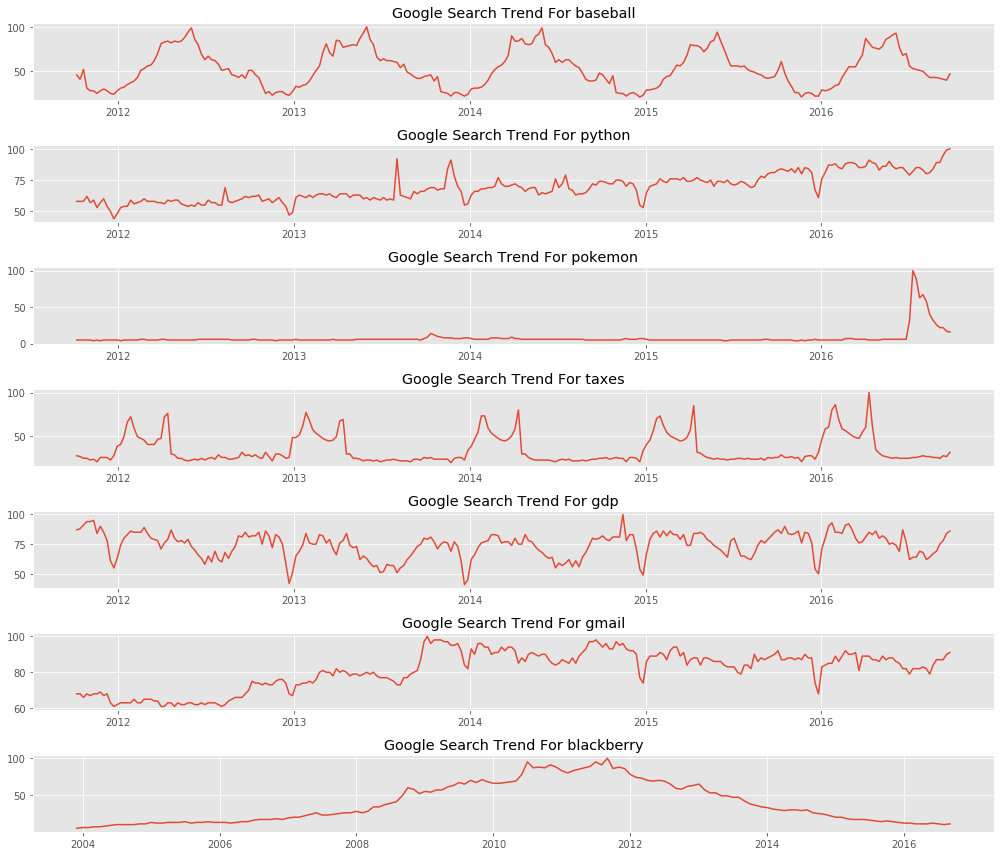

In [5]:
fig, axs = plt.subplots(len(google_trends), figsize=(14, 12))

for ax, name in zip(axs, google_search_names):
    plot_trend_data(ax, name, load_google_trend_data(name))
    
plt.tight_layout()

Some observations:

  - Searches for **baseball** show very strong oscillations aligned with the baseball season.  Search volume increases quickly as the season begins, and then falls off as the season goes on.
  - Searches for **python** show a general increase over time, probably influenced by the popularity of the language itself.  There may be evidence that searches decrease as specific periods of the year, most noticeably the end of year, when people are not working.
  - Searches for **pokemon** spike suddenly at a recent date, pointing to a one-time event greatly increasing interest.
  - Searches for **taxes** spike regularly at two specific points of the year, with the interest being heightened between those two dates.  At other times of the year, searches revert to a low rate.
  - Searches for **gdp** show a more random pattern than the others.  There is some evidence for *stickiness* in the trend, low values beget low subsequent values, and high values beget high subsequent values.
  - Searches for **gmail** show a pattern reminiscent of python, but there are sudden shifts where the baseline level jumps to a new value.
  - Searches for **blackberry** have a non-linear trend over time, they increase to a peak popularity, then decrease to almost nothing.

**Activity:** Load and plot the trend data for "data-science", what patterns do you see?

## Basic Concepts

Various different time series often show common patterns.  Attaching words to these patterns allows us to build a common language to discuss time series.

### Trends

A **trend** in a time series is a gradual change in average level as time moves on.  A trend can be *increasing*, *decreasing*, or *neither* (if, for example, a trend changes direction at some point in time). 

Searches for **python** show a steady increasing trend.

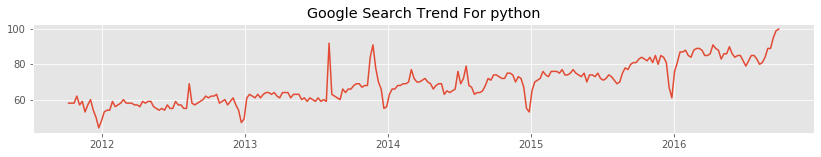

In [6]:
fig, ax = plt.subplots(1, figsize=(14, 2))
plot_trend_data(ax, 'python', google_trends['python'])

Searches for **blackberry** show a non-linear trend.

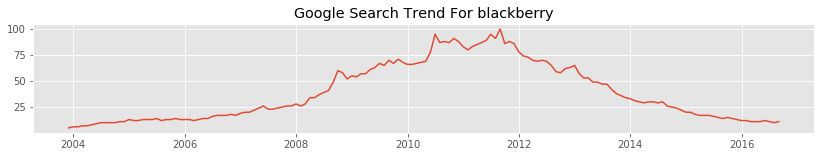

In [7]:
fig, ax = plt.subplots(1, figsize=(14, 2))
plot_trend_data(ax, 'blackberry', google_trends['blackberry'])

**Question:** How do you describe the trend in `data-science`?

You can often use a regression model(\*) to capture a general trend in the series.

Let's try to capture the linear trend in the python search data by fitting a simple linear model and using its predictions on the training data.

(\*) yes, even though time-series values are often correlated.

In [8]:
def to_col_vector(arr):
    """Convert a one dimensional numpy array to a column vector."""
    return arr.reshape(-1, 1)

def make_design_matrix(arr):
    """Construct a design matrix from a numpy array, including an intercept term."""
    return sm.add_constant(to_col_vector(arr), prepend=False)

In [9]:
def fit_linear_trend(series):
    """Fit a linear trend to a time series.  Return the fit trend as a numpy array."""
    X = make_design_matrix(np.arange(len(series)) + 1)
    linear_trend_ols = sm.OLS(series.values, X).fit()
    linear_trend = linear_trend_ols.predict(X)
    return linear_trend

In [10]:
def plot_linear_trend(ax, name, series):
    linear_trend = fit_linear_trend(series)
    plot_trend_data(ax, name, series)
    ax.plot(series.index, linear_trend)

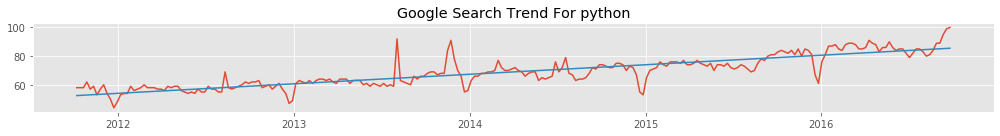

In [11]:
fig, ax = plt.subplots(1, figsize=(14, 2))
plot_linear_trend(ax, 'python', google_trends['python'])
plt.tight_layout()

If we subtract out the fit trend from the original series, we get the **detrended series**.

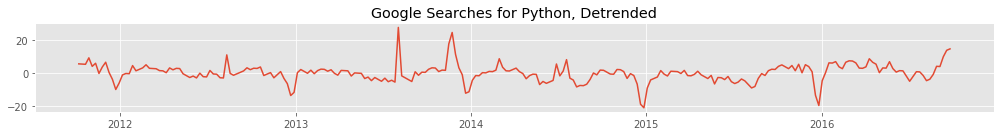

In [12]:
python_series = google_trends['python']
python_linear_trend = fit_linear_trend(python_series)
python_series_detrended = python_series - python_linear_trend

fig, ax = plt.subplots(1, figsize=(14, 2))
ax.plot(python_series_detrended.index, python_series_detrended)
ax.set_title("Google Searches for Python, Detrended")
plt.tight_layout()

Detrending a series is often times a first step in analysing a time series.

Many times time series show a more sophisticated trend than a simple linear increase or decrease, in these cases a more sophisticated detrending procedure is needed.

In the following two cases, a linear detrending would be clearly inappropriate.

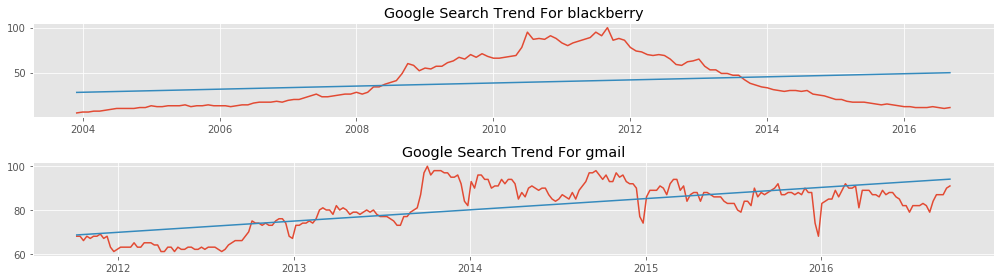

In [13]:
fig, axs = plt.subplots(2, figsize=(14, 4))
plot_linear_trend(axs[0], 'blackberry', google_trends['blackberry'])
plot_linear_trend(axs[1], 'gmail', google_trends['gmail'])
plt.tight_layout()

**Question:** Can you describe precisely what is wrong with the linear model in both of these cases?

A very general approach that can be used for detrending data is to compute a **moving average**.

The moving average estimate of the trend at a data point $y_i$ is

$$ \hat y_i = \frac{1}{w} \sum_{j = -w/2}^{w/2} y_{i + j} $$

We esentially slide a *window* of a fixed side across our data, and average the values of the series within the window.

The parameter $w$ controls how far to the left and to the right of $i$ we look when averaging the nearby points, this is called the **window**.

In [14]:
# here's a quick example
df = pd.DataFrame({'val': [0, 1, 2, 3, 4, 5, 6]})
rolling_results = df.rolling(2, center=True).mean()
rolling_results

,val
0,NaN
1,0.5
2,1.5
3,2.5
4,3.5
5,4.5
6,5.5


In [15]:
# Go to functions, note the window here is 6
def fit_moving_average_trend(series, window=6):
    return series.rolling(window, center=True).mean()

def plot_moving_average_trend(ax, name, series, window=6):
    moving_average_trend = fit_moving_average_trend(series, window)
    plot_trend_data(ax, name, series)
    ax.plot(series.index, moving_average_trend)

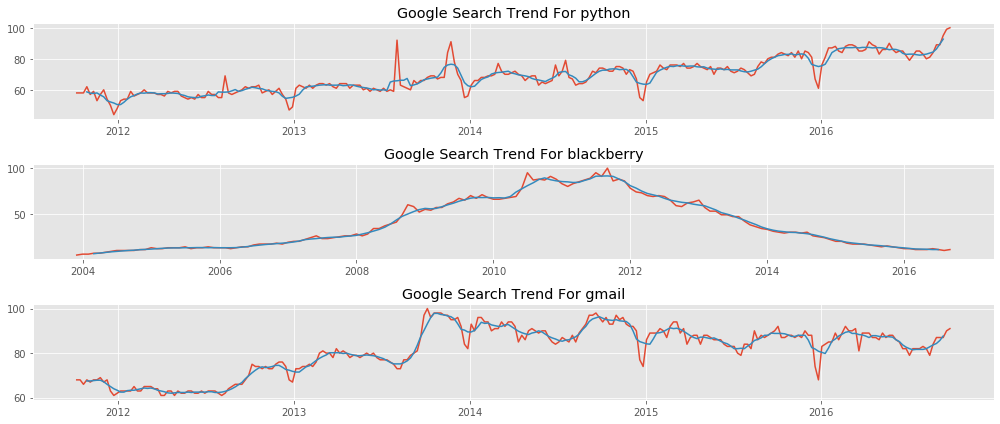

In [16]:
fig, axs = plt.subplots(3, figsize=(14, 6))
plot_moving_average_trend(axs[0], 'python', google_trends['python'])
plot_moving_average_trend(axs[1], 'blackberry', google_trends['blackberry'])
plot_moving_average_trend(axs[2], 'gmail', google_trends['gmail'])
plt.tight_layout()

Varying the window parameter changes the quality of the moving average fit

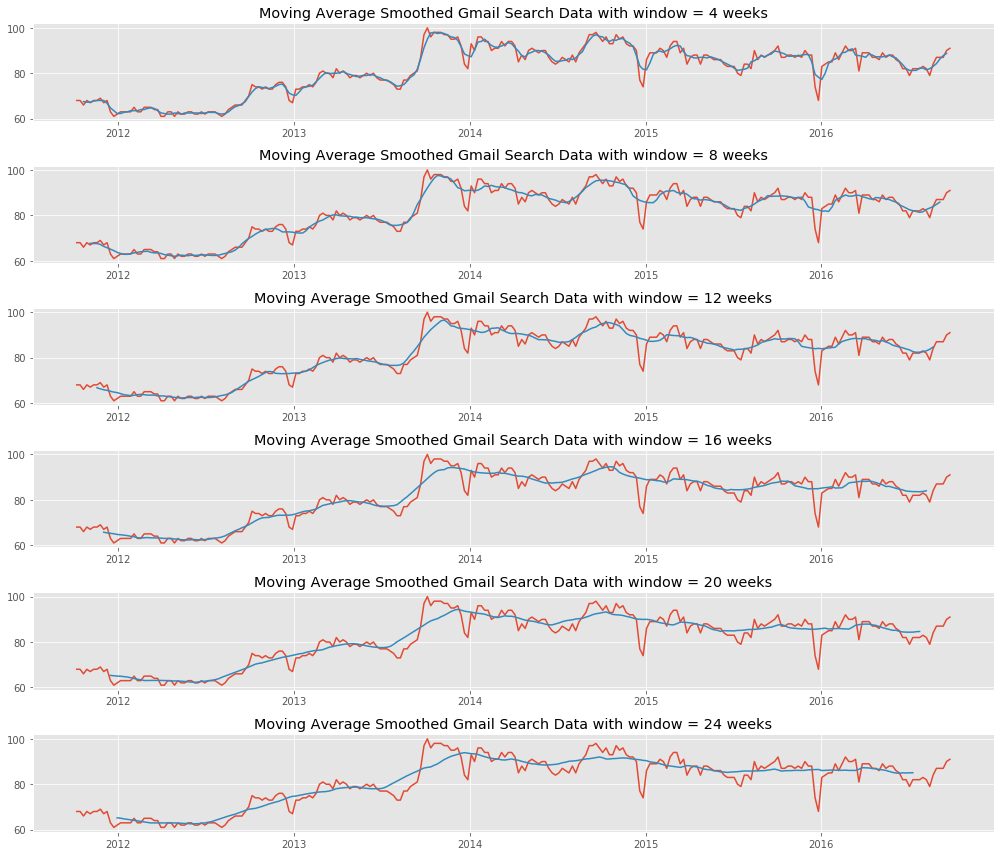

In [17]:
fig, axs = plt.subplots(6, figsize=(14, 12))

gmail_series = google_trends['gmail']
for i, window in enumerate([4, 8, 12, 16, 20, 24]):
    axs[i].plot(gmail_series.index, gmail_series)
    axs[i].plot(gmail_series.index, fit_moving_average_trend(gmail_series, window=window))
    axs[i].set_title("Moving Average Smoothed Gmail Search Data with window = {} weeks".format(window))
    
plt.tight_layout()

We see that:

  - Smaller values of `window` will tend to be influenced by noise of other non-trend patterns in the series.
  - Large values of `window` produce smoother estimates of the general trend in the data.
  
For this reason, when estimating the trend component of a time series, we generally prefer larger windows.

When we have data that aligns with calendar regularities (quarterly, weekly, yearly), it is a good idea to chose the window so that an entire annual cycle is used to find the trend.  This will average out any **seasonal** patterns in the data, as we will discuss below.

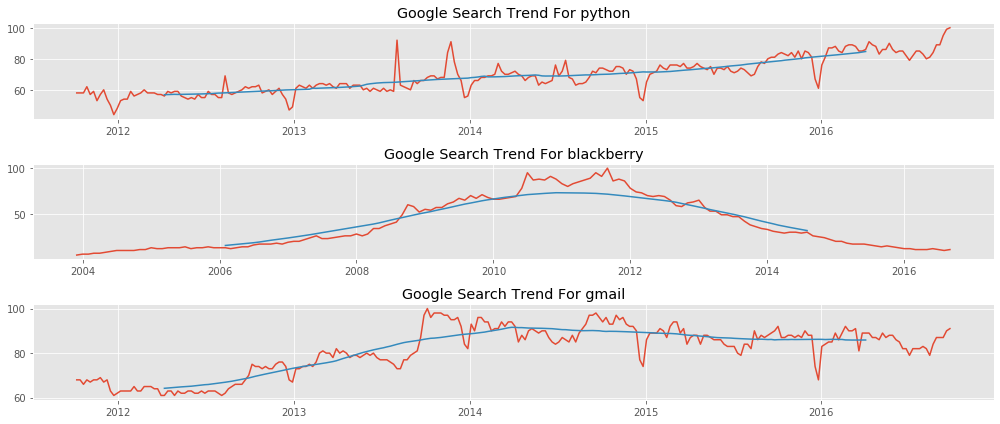

In [18]:
# 52 weeks in a year
fig, axs = plt.subplots(3, figsize=(14, 6))
plot_moving_average_trend(axs[0], 'python', google_trends['python'], window=52)
plot_moving_average_trend(axs[1], 'blackberry', google_trends['blackberry'], window=52)
plot_moving_average_trend(axs[2], 'gmail', google_trends['gmail'], window=52)
plt.tight_layout()

### Seasonality

A **seasonal** pattern in a time series is one that tends to appear regularly, and often aligns with features of the calendar.

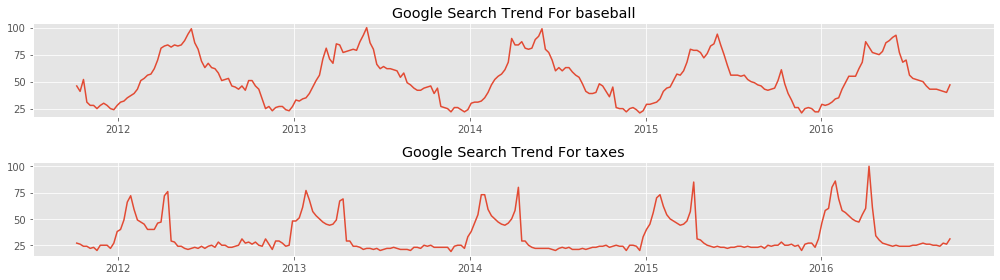

In [19]:
fig, axs = plt.subplots(2, figsize=(14, 4))
plot_trend_data(axs[0], 'baseball', google_trends['baseball'])
plot_trend_data(axs[1], 'taxes', google_trends['taxes'])
plt.tight_layout()

Just like we can de**trend** a time series, we can also **deseasonalize** a time series.

The simplest method is to create dummy variables at regular intervals of the calender
  - A dummy for each month.
  - A dummy for each season.
  
and then fit a linear regression to the series using these dummy variables.

In [20]:
# for example
series = google_trends['baseball']
print(series.head())
print()
month = series.index.month
print(month)
print(month.value_counts())

week
2011-10-08    46
2011-10-15    41
2011-10-22    52
2011-10-29    31
2011-11-05    28
Name: baseball, dtype: int64

Int64Index([10, 10, 10, 10, 11, 11, 11, 11, 12, 12,
            ...
             7,  7,  8,  8,  8,  8,  9,  9,  9,  9],
           dtype='int64', name='week', length=260)
8     23
3     23
12    22
11    22
6     22
5     22
1     22
10    21
9     21
7     21
4     21
2     20
Name: week, dtype: int64


In [21]:
dummies = pd.get_dummies(month).iloc[:,:11]
dummies

,1,2,3,4,5,6,7,8,9,10,11
0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
255,0,0,0,0,0,0,0,1,0,0,0
256,0,0,0,0,0,0,0,0,1,0,0
257,0,0,0,0,0,0,0,0,1,0,0
258,0,0,0,0,0,0,0,0,1,0,0


In [22]:
X = sm.add_constant(dummies.values, prepend=False)
X

array([[0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [23]:
seasonal_model = sm.OLS(series.values, X).fit()
season = seasonal_model.predict(X)
season[:10]

array([43.71428571, 43.71428571, 43.71428571, 43.71428571, 25.31818182,
       25.31818182, 25.31818182, 25.31818182, 24.90909091, 24.90909091])

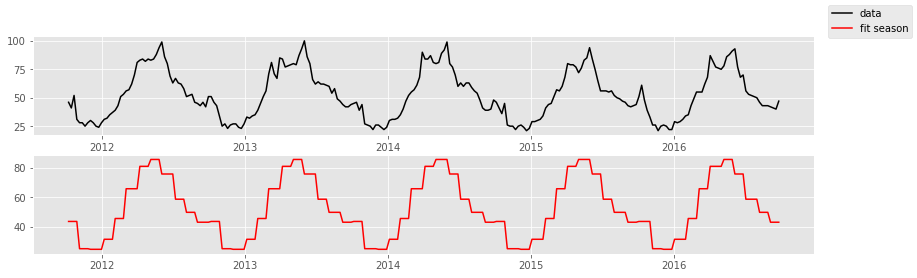

In [24]:
fig, axs = plt.subplots(2, figsize=(14, 4))
axs[0].plot(series.index, series, label='data', c='k')
axs[1].plot(series.index, season, label='fit season', c='r')
fig.legend();

### Put everything in functions

In [25]:
def create_monthly_dummies(series):
    month = series.index.month
    # Only take 11 of the 12 dummies to avoid strict colinearity.
    return pd.get_dummies(month).iloc[:, :11]

In [26]:
def fit_seasonal_trend(series):
    dummies = create_monthly_dummies(series)
    X = sm.add_constant(dummies.values, prepend=False)
    seasonal_model = sm.OLS(series.values, X).fit()
    return seasonal_model.predict(X)

In [27]:
def plot_seasonal_trend(ax, name, series):
    seasons_average_trend = fit_seasonal_trend(series)
    plot_trend_data(ax, name, series)
    ax.plot(series.index, seasons_average_trend)

Here are linear regression models fit to the baseball and taxes trends with monthly dummy variables.

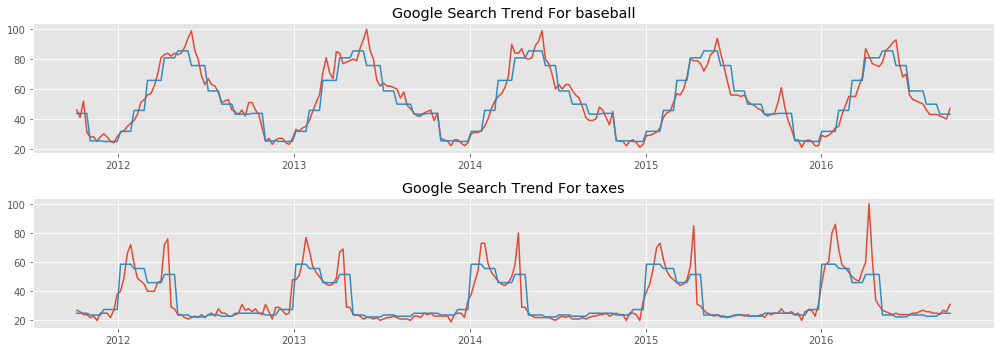

In [28]:
fig, axs = plt.subplots(2, figsize=(14, 5))

plot_seasonal_trend(axs[0], 'baseball', google_trends['baseball'])
plot_seasonal_trend(axs[1], 'taxes', google_trends['taxes'])
plt.tight_layout()

To deseasonalize, we simply subtract out the seasonal predictions.

Text(0.5, 1.0, 'Google Searches for Baseball, Deseasonalized')

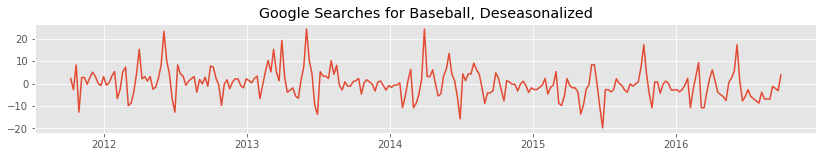

In [29]:
baseball_series = google_trends['baseball']
baseball_seasonal_trend = fit_seasonal_trend(baseball_series)
baseball_seasonal_detrended = baseball_series - baseball_seasonal_trend

fig, ax = plt.subplots(1, figsize=(14, 2))
ax.plot(baseball_series.index, baseball_seasonal_detrended)
ax.set_title("Google Searches for Baseball, Deseasonalized")

Text(0.5, 1.0, 'Google Searches for Taxes, Deseasonalized')

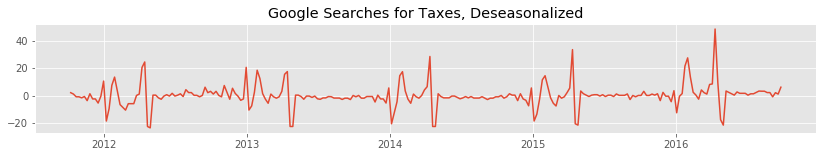

In [30]:
tax_series = google_trends['taxes']
tax_seasonal_trend = fit_seasonal_trend(tax_series)
tax_seasonal_detrended = tax_series - tax_seasonal_trend

fig, ax = plt.subplots(1, figsize=(14, 2))
ax.plot(tax_series.index, tax_seasonal_detrended)
ax.set_title("Google Searches for Taxes, Deseasonalized")

**Question:** Have we removed the seasonality from these series?  What more could we do?

## Trend-Seasonal-Residual Decomposition

The **Classical Trend-Seasonal-Residual Decomposition** expresses a time series as the sum of three components:

$$ y_t = T_t + S_t + R_t $$

and is accomplished as follows.

Suppose, for definiteness, that we are working with *weekly* data, so that each $52$ observations forms a calender year.  Then, the series is decomposed as follows:

1. Compute the trend component $T_t$ using a moving average with window width $52$ (or $12$ for monthly data.  Then detrend the series.
2. Compute the seasonal component $S_t$ of the detrended series $y_t - T_t$ by averaging together the observations that fall in the same week (or month, if monthly data).  **Note**, this is *equivalent* to fitting a linear regression to the detrended data with an indicator for each week, and then making predictions for each week of the original series.
3. The **remainder**, or **error**, or **residual** series $E_t$ is $y_t - T_t - S_t$.

**Forecasting**: 
<br>
To make a prediction in the future, add the expected trend value and seasonal value at the point in time in the future.  (Don't add residual - it's noise).

Statsmodels implements the classical decomposition as `seasonal_decompose`.

In [31]:
python_decomposition = sm.tsa.seasonal_decompose(google_trends['python'])

In [32]:
def plot_seasonal_decomposition(axs, series, sd):
    axs[0].plot(series.index, series)
    axs[0].set_title("Raw Series")
    axs[1].plot(series.index, sd.trend)
    axs[1].set_title("Trend Component $T_t$")
    axs[2].plot(series.index, sd.seasonal)
    axs[2].set_title("Seasonal Component $S_t$")
    axs[3].plot(series.index, sd.resid)
    axs[3].set_title("Residual Component $R_t$")

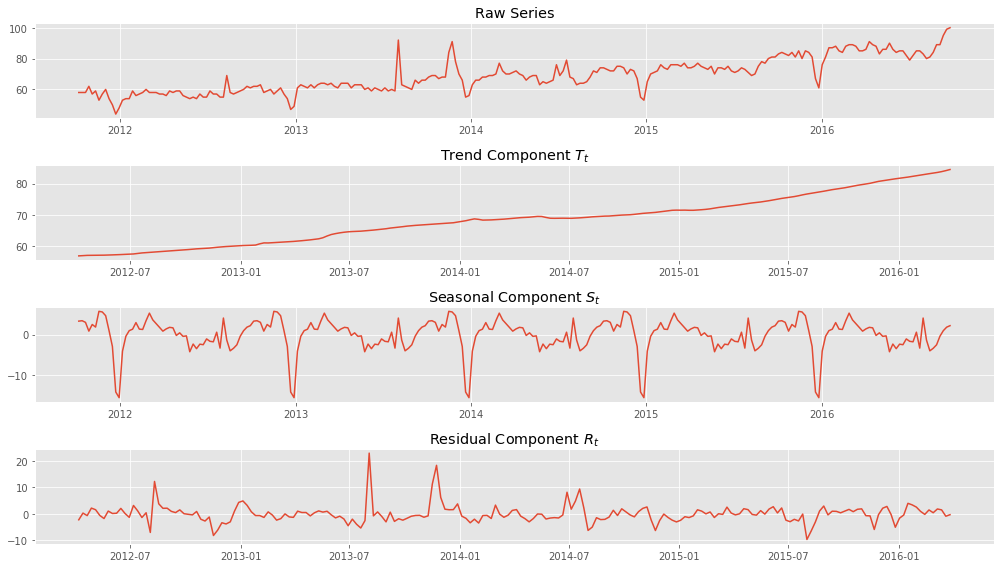

In [33]:
fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, google_trends['python'], python_decomposition)
plt.tight_layout()

This decomposition validates our description of the series earlier as a general upwards trend, but with some seasonal behaviour (like a sharp drop off in queries around wintertime).

When the decomposition is working well, the residual component $R_t$ should show no seasonal or trend patterns.

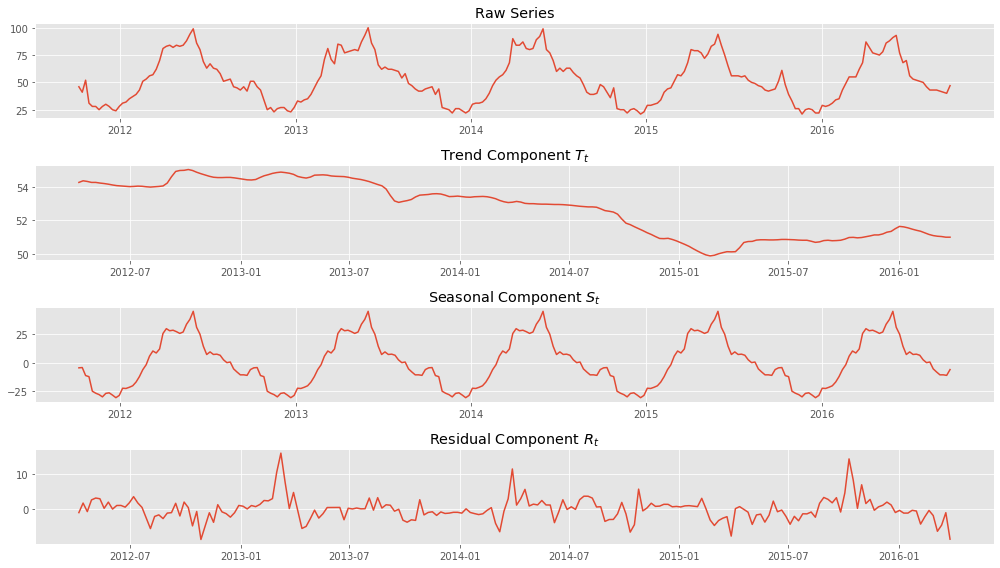

In [34]:
baseball_decomposition = sm.tsa.seasonal_decompose(google_trends['baseball'])

fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, google_trends['baseball'], baseball_decomposition)
plt.tight_layout()

**Note:** The different components of the series are often shown on very different scales, so make sure to pay close attention to the $y$-axis labels.

Sometimes the classical decomposition is not powerful enough to capture the trend or seasonal components of a time series.

The gmail series decomposition shows some interesting behaviour in the residuals:

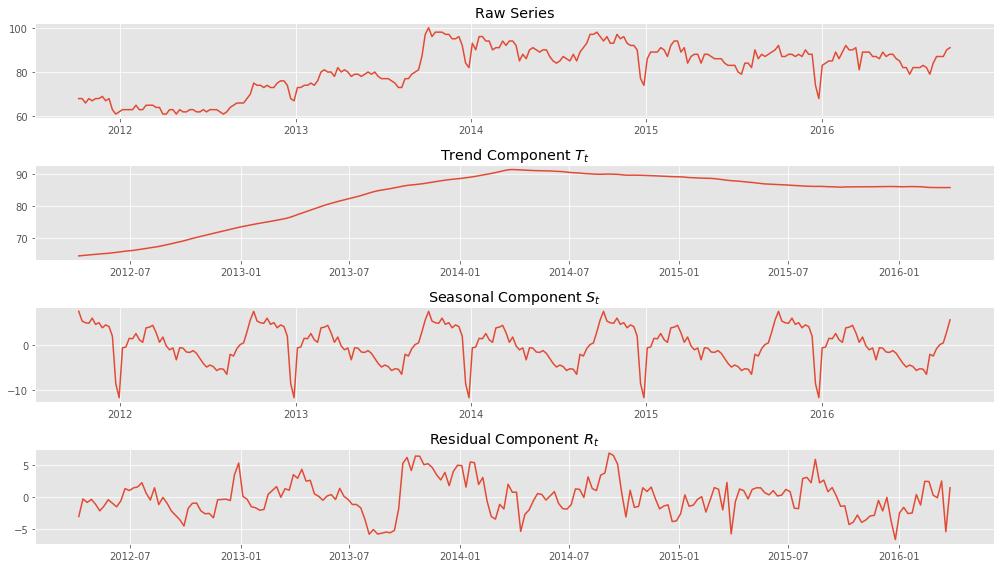

In [35]:
gmail_decomposition = sm.tsa.seasonal_decompose(google_trends['gmail'])

fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, google_trends['gmail'], gmail_decomposition)
plt.tight_layout()

Around October 2013 the series showed a clear and sudden change in average level, which the trend component could not adapt to quickly enough.  Consequently, this discontinuity appears in the residual series.

A more sophisticated procedure should be used to decompose this series, which allows for a discontinuity in the observed series, or fits a more sophisticated model for the trend component.

### The above concepts will get you through the Time Series assignment.  

However, if you are going to get serious about Forecasting, you'll need to be able to talk about and implement **ARIMA** (AutoRegressive Integrated Moving Average) as well as some other time series approaches (**supervised learning using lagged features**) and **recurrent neural nets** (LSTMs).

Here are a few blogs of blogs for your reference:
* [Feature engineering time series data](https://machinelearningmastery.com/basic-feature-engineering-time-series-data-python/)
* [Supervised learning time series data](https://machinelearningmastery.com/feature-selection-time-series-forecasting-python/)
* [Forecasting with LSTMs](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)

We have future lectures on **ARIMA** and **recurrent neural nets**.